# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2, sys, os
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


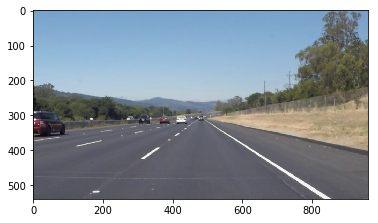

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

## Ideas for Lane Detection Pipeline

In [85]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# From stackoverflow - https://stackoverflow.com/questions/11686720/is-there-a-numpy-builtin-to-reject-outliers-from-a-list
def reject_outliers(data, m = 2.):
   return data[abs(data - np.mean(data)) < m * np.std(data)]

def draw_lines(img, lines, ll_am, ll_ac, rl_am, rl_ac, color=[255, 0, 0], thickness=5):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    y_max = img.shape[0]
    x_max = img.shape[1]
    
    ll_m =[]
    ll_c =[]
    
    rl_m =[]
    rl_c =[]
    
    THRESHOLD = 200
    
    STARTUP = ll_am==0 and ll_ac==0 and rl_am ==0 and rl_ac==0
      
    color2=[0, 0, 255]
    for line in lines:
        for x1,y1,x2,y2 in line:        
            m = ((y2-y1)/(x2-x1))
            c =(y2-m*x2 + y1-m*x1)/2
            if m > 0:
                if(m > 0.45):
                    # validation - rl_m and rl_c should not differ more than THRESHOLD% rl_am, rl_ac
                    if(((abs(rl_ac - c)) < THRESHOLD) or STARTUP):#(abs(rl_am - m)/rl_am < THRESHOLD) and 
                        #print ('r: {}'.format(m))
                        rl_m.append(m)
                        rl_c.append(c)                   
                    #else:
                        #print ('r', m,c)
                        #print (rl_ac,c)
                    #cv2.line(img, (x1, y1), (x2, y2), [0, 0, 255], thickness)
            elif (m < 0):
                if(m < -0.45):
                    # validation - ll_m and ll_c should not differ more than THRESHOLD% ll_am, ll_ac
                    if((abs(ll_ac - c)< THRESHOLD or STARTUP)):
                        #print ('l: {}'.format(m))
                        ll_m.append(m)
                        ll_c.append(c)
                    #else:
                        #print ('l',abs(ll_am - m)/ll_am,abs(ll_ac - c)/ll_ac)
                    #cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], thickness)
    
    # Set current frame mean and c for ll & rl
   
     # Draw for left lane
    # Compute median of m and c
    m = np.mean(reject_outliers(np.asarray(ll_m)))
    c = np.mean(reject_outliers(np.asarray(ll_c)))
    try:
        assert(m!=0)
        assert(math.isnan(m)==False)
        assert(math.isnan(c)==False)
        if (STARTUP):
            ll_bottom_x = int((y_max - c)/m)
            ll_top_x = int((y_max/2+60 - c)/m)
        else:
            ll_bottom_x = int((y_max - ll_ac)/ll_am)
            ll_top_x = int((y_max/2+60 - ll_ac)/ll_am)
        cv2.line(img, (ll_bottom_x, y_max), (ll_top_x, int(y_max/2)+60), color, thickness)
        ll_m = m
        ll_c = c
    except AssertionError as error:
        #print('Assertion Error ll')
        #print(ll_m,ll_c,m,c)
        ll_m = ll_am
        ll_c = ll_ac
        ll_bottom_x = int((y_max - ll_ac)/ll_am)
        ll_top_x = int((y_max/2+60 - ll_ac)/ll_am)
        cv2.line(img, (ll_bottom_x, y_max), (ll_top_x, int(y_max/2)+60), color, thickness)
        #sys.exit()
   
    
    # Draw for right lane
    m = np.mean(reject_outliers(np.asarray(rl_m)))
    c = np.mean(reject_outliers(np.asarray(rl_c))) 
    try:
        assert(m!=0)
        assert(math.isnan(m)==False)
        assert(math.isnan(c)==False)
        #print ('rl',m,c)
        if(STARTUP):
            rl_bottom_x = int((y_max - c)/m)
            rl_top_x = int(((y_max/2+60) - c)/m)
        else:
            rl_bottom_x = int((y_max - rl_ac)/rl_am)
            rl_top_x = int(((y_max/2+60) - rl_ac)/rl_am)
        cv2.line(img, (rl_bottom_x, y_max), (rl_top_x, int(y_max/2)+60), color, thickness)
        rl_m = m
        rl_c = c
    except AssertionError as error:
        #print('Assertion Error  rl')
        #print(rl_m,rl_c,m,c)
        rl_m = rl_am
        rl_c = rl_ac 
        rl_bottom_x = int((y_max - rl_ac)/rl_am)
        rl_top_x = int(((y_max/2+60) - rl_ac)/rl_am)
        cv2.line(img, (rl_bottom_x, y_max), (rl_top_x, int(y_max/2)+60), color, thickness)
    
    return ll_m, ll_c, rl_m, rl_c

def hough_lines_averaging(img, rho, theta, threshold, min_line_len, max_line_gap, ll_am, ll_ac, rl_am, rl_ac):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    ll_m, ll_c, rl_m, rl_c = draw_lines(line_img, lines, ll_am, ll_ac, rl_am, rl_ac)
    return line_img, ll_m, ll_c, rl_m, rl_c    
    
# def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
#     """
#     `img` should be the output of a Canny transform.
        
#     Returns an image with hough lines drawn.
#     """
#     lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
#     line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
#     #draw_lines(line_img, lines)
#     return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [74]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [75]:
def lane_detect(image, ll_am, ll_ac, rl_am, rl_ac):
    # TODO: Build your pipeline that will draw lane lines on the test_images
    # then save them to the test_images_output directory.
    # 1. Grayscale
    gray = grayscale(image)
    #plt.imshow(gray, cmap='gray') 
    # 2. Gaussian Smoothing
    blur_gray = gaussian_blur(gray, 5)
    # plt.imshow(blur_gray,cmap='gray')
    # 3. Canny 
    edges = canny(blur_gray, 50, 150)
    #plt.imshow(edges,cmap='gray')
    # 4. ROI/Masking
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(imshape[1]/2-20, imshape[0]/2+60), (imshape[1]/2+20, imshape[0]/2+60), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_edge = region_of_interest(edges, vertices)
    #plt.imshow(masked_edge,cmap='gray')
    # 5. Hough Lines
    rho = 2
    theta = (np.pi/180)
    threshold = 15
    min_line_length = 20
    max_line_gap = 20
    lines,ll_m, ll_c, rl_m, rl_c = hough_lines_averaging(masked_edge, rho, theta, threshold, min_line_length, max_line_gap, ll_am, ll_ac, rl_am, rl_ac)
    return weighted_img(lines, image), ll_m, ll_c, rl_m, rl_c
    

In [76]:
test_images = os.listdir("test_images/")
for image in test_images:
    print(image)
    image_file = mpimg.imread('test_images/'+ image)
    lanes_image,ll_m, ll_c, rl_m, rl_c = lane_detect(image_file, 0,0,0,0)
    #plt.imshow(lanes_image)
    mpimg.imsave('results/'+image, lanes_image)
    print (ll_m, ll_c, rl_m, rl_c)

solidWhiteCurve.jpg
rl 0.558833400791 43.898879475
-0.797991602089 690.278067532 0.558833400791 43.898879475
solidWhiteRight.jpg
rl 0.637758088082 2.16151164638
-0.687947255733 639.583304776 0.637758088082 2.16151164638
solidYellowCurve.jpg
rl 0.604862430336 23.4545936488
-0.704521718217 655.258270225 0.604862430336 23.4545936488
solidYellowCurve2.jpg
rl 0.550390731896 55.1283094319
-0.784934265882 681.475568429 0.550390731896 55.1283094319
solidYellowLeft.jpg
rl 0.621266690792 11.2746001028
-0.696471702428 639.89888153 0.621266690792 11.2746001028
whiteCarLaneSwitch.jpg
rl 0.558978336748 45.7232927282
-0.758016494869 671.131894055 0.558978336748 45.7232927282


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [77]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import collections

ll_am_coll = collections.deque(maxlen=10)
ll_ac_coll = collections.deque(maxlen=10)
rl_am_coll = collections.deque(maxlen=10)
rl_ac_coll = collections.deque(maxlen=10)


In [78]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    # Averaging slope and c for ll and rl 
    if(len(ll_am_coll) > 9):
        result, ll_m, ll_c, rl_m, rl_c = lane_detect(image, np.mean(ll_am_coll),  np.mean(ll_ac_coll),  np.mean(rl_am_coll),  np.mean(rl_ac_coll))
        #print ('Vals')
    else:
        result, ll_m, ll_c, rl_m, rl_c = lane_detect(image, 0, 0, 0, 0)
        #print ('0s')
    ll_am_coll.append(ll_m)
    ll_ac_coll.append(ll_c)
    rl_am_coll.append(rl_m)
    rl_ac_coll.append(rl_c)
    return result

Let's try the one with the solid white lane on the right first ...

In [79]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")

white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()

rl 0.643148678198 -6.81581766389
0s
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|                                                                                                                                               | 0/222 [00:00<?, ?it/s]

rl 0.643148678198 -6.81581766389
0s
rl 0.630761186544 -1.63744438276
0s
rl 0.594528311627 23.8426869829
0s


  1%|█▊                                                                                                                                     | 3/222 [00:00<00:07, 29.12it/s]

rl 0.611450506405 13.3948187719
0s
rl 0.606849246934 16.616702232
0s
rl 0.627194467559 -1.01025103652
0s
rl 0.610212563438 12.6210243901
0s


  3%|████▎                                                                                                                                  | 7/222 [00:00<00:06, 32.70it/s]

rl 0.615392919316 9.65241917406
0s
rl 0.613741126303 10.9298089088
0s
rl 0.607439229219 17.64338078
Vals
rl 0.577756377752 36.1703976644
Vals


  5%|██████▋                                                                                                                               | 11/222 [00:00<00:06, 33.63it/s]

rl 0.613824517921 20.1829324533
Vals
rl 0.63248000709 4.49647606135
Vals
rl 0.614712043683 18.1043371031
Vals
rl 0.633270754205 2.04532501511
Vals


  7%|█████████                                                                                                                             | 15/222 [00:00<00:06, 34.08it/s]

rl 0.639573827044 -1.93208513732
Vals
rl 0.657034936706 -13.5532351477
Vals
rl 0.655482413466 -18.0409998199
Vals
rl 0.633891419978 5.45553593292
Vals


  9%|███████████▍                                                                                                                          | 19/222 [00:00<00:05, 34.28it/s]

rl 0.634767067222 3.97043107993
Vals
rl 0.631701756547 5.70812319022
Vals
rl 0.661436238201 -12.0455317953
Vals
rl 0.632143559126 4.67117837699
Vals


 10%|█████████████▉                                                                                                                        | 23/222 [00:00<00:05, 34.63it/s]

rl 0.638218668495 1.31287036353
Vals
rl 0.628204061346 10.1668706655
Vals
rl 0.635577370058 2.3826896316
Vals
rl 0.624163752489 4.87171230322
Vals


 12%|████████████████▎                                                                                                                     | 27/222 [00:00<00:05, 34.56it/s]

rl 0.633105750656 3.76951533109
Vals
rl 0.63647708987 0.5478682986
Vals
rl 0.621242711739 15.2454332711
Vals
rl 0.649119560728 -5.26637063579
Vals


 14%|██████████████████▋                                                                                                                   | 31/222 [00:00<00:05, 34.02it/s]

rl 0.639277324217 -5.64913297293
Vals
rl 0.641697611426 -6.66637290272
Vals
rl 0.632551809031 -0.248591188483
Vals
rl 0.637374491717 -0.857963772562
Vals


 16%|█████████████████████▏                                                                                                                | 35/222 [00:01<00:05, 34.07it/s]

rl 0.628006803164 4.33916602208
Vals
rl 0.637482942369 3.14129227361
Vals
rl 0.638671699775 1.91768285657
Vals
rl 0.65274037627 -11.1218437329
Vals


 18%|███████████████████████▌                                                                                                              | 39/222 [00:01<00:05, 33.35it/s]

rl 0.629070836213 9.64557936038
Vals
rl 0.64075109014 -1.09645430137
Vals
rl 0.639722836883 1.56849285669
Vals
rl 0.665192443853 -19.7727756783
Vals


 19%|█████████████████████████▉                                                                                                            | 43/222 [00:01<00:05, 33.14it/s]

rl 0.671429157262 -21.2918041163
Vals
rl 0.642412958374 -4.56854030528
Vals
rl 0.667956406584 -18.9147236838
Vals
rl 0.646977421595 -6.35021832425
Vals


 21%|████████████████████████████▎                                                                                                         | 47/222 [00:01<00:05, 30.71it/s]

rl 0.647542832346 -11.022198941
Vals
rl 0.646031745518 -6.69201741553
Vals
rl 0.632803343527 0.915871028473
Vals
rl 0.660556189443 -16.8219064614
Vals


 23%|██████████████████████████████▊                                                                                                       | 51/222 [00:01<00:05, 30.64it/s]

rl 0.626543361557 4.92192378116
Vals
rl 0.659620179344 -14.4085628509
Vals
rl 0.651332282794 -11.7393046547
Vals


 24%|████████████████████████████████▌                                                                                                     | 54/222 [00:01<00:05, 29.51it/s]

rl 0.639711222004 -2.45741880626
Vals
rl 0.637829936018 3.56727450011
Vals
rl 0.638808073057 3.95135891122
Vals


 26%|██████████████████████████████████▍                                                                                                   | 57/222 [00:01<00:05, 28.68it/s]

rl 0.637888557804 2.0187882623
Vals
rl 0.628855331292 10.4428389011
Vals
rl 0.658271452397 -14.7279795902
Vals


 27%|████████████████████████████████████▏                                                                                                 | 60/222 [00:02<00:05, 28.35it/s]

rl 0.65880183056 -11.7795126423
Vals
rl 0.657182906632 -10.2068458949
Vals
rl 0.665596930031 -15.5874618136
Vals


 28%|██████████████████████████████████████                                                                                                | 63/222 [00:02<00:05, 27.53it/s]

rl 0.670954201821 -20.0895116451
Vals
rl 0.662254821388 -11.1663059021
Vals
rl 0.656865258054 -11.319969831
Vals


 30%|███████████████████████████████████████▊                                                                                              | 66/222 [00:02<00:05, 27.33it/s]

rl 0.669062930064 -18.8275973052
Vals
rl 0.657602192178 -14.3185547952
Vals
rl 0.640840362113 6.45904186851
Vals


 31%|█████████████████████████████████████████▋                                                                                            | 69/222 [00:02<00:05, 26.56it/s]

rl 0.669789706388 -17.7544146752
Vals
rl 0.672522359182 -18.9931744495
Vals
r 1.0 -225.0
-13.1804794443 -225.0
rl 0.662524476621 -12.8062511206
Vals


 32%|███████████████████████████████████████████▍                                                                                          | 72/222 [00:02<00:05, 25.86it/s]

rl 0.664094672077 -14.6318216615
Vals
rl 0.64599495431 -3.81866189991
Vals
rl 0.667176907361 -18.1435357911
Vals


 34%|█████████████████████████████████████████████▎                                                                                        | 75/222 [00:02<00:05, 25.72it/s]

rl 0.664535567625 -10.7235259715
Vals
rl 0.66863204125 -14.3693160039
Vals
rl 0.65587458991 -5.93069528768
Vals


 35%|███████████████████████████████████████████████                                                                                       | 78/222 [00:03<00:05, 25.77it/s]

rl 0.684687641092 -29.297238118
Vals
rl 0.679110614668 -19.0854322526
Vals
rl 0.683596374093 -21.7507181586
Vals


 36%|████████████████████████████████████████████████▉                                                                                     | 81/222 [00:03<00:05, 25.31it/s]

rl 0.650361199437 -4.59952022246
Vals
rl 0.67143934689 -13.7560299576
Vals
rl 0.658166817604 -8.66511263421
Vals


 38%|██████████████████████████████████████████████████▋                                                                                   | 84/222 [00:03<00:05, 25.19it/s]

rl 0.682680275857 -26.2863771065
Vals
rl 0.683312299629 -25.4136616204
Vals
rl 0.684874005278 -23.5436314739
Vals


 39%|████████████████████████████████████████████████████▌                                                                                 | 87/222 [00:03<00:05, 24.76it/s]

rl 0.689574972854 -27.8474364901
Vals
rl 0.684294123462 -26.12095647
Vals
rl 0.712581756535 -39.7628081625
Vals


 41%|██████████████████████████████████████████████████████▎                                                                               | 90/222 [00:03<00:05, 24.77it/s]

rl 0.702470952781 -35.6386031048
Vals
rl 0.690163464299 -25.1732205163
Vals
rl 0.704785271781 -34.9337292233
Vals


 42%|████████████████████████████████████████████████████████▏                                                                             | 93/222 [00:03<00:05, 24.50it/s]

rl 0.713064219818 -40.9046386393
Vals
rl 0.699955791129 -34.0168353588
Vals
rl 0.692308485847 -26.608978244
Vals


 43%|█████████████████████████████████████████████████████████▉                                                                            | 96/222 [00:03<00:05, 24.38it/s]

rl 0.723451367201 -50.3253136441
Vals
rl 0.693845915352 -30.2804643708
Vals
rl 0.66988921153 -16.2709949301
Vals


 45%|███████████████████████████████████████████████████████████▊                                                                          | 99/222 [00:04<00:05, 24.09it/s]

rl 0.7040898446 -40.9777706716
Vals
rl 0.699854860978 -36.4754354605
Vals
rl 0.679839525889 -18.6057250549
Vals


 46%|█████████████████████████████████████████████████████████████                                                                        | 102/222 [00:04<00:04, 24.16it/s]

rl 0.683906683057 -25.9522946211
Vals
rl 0.669941245085 -16.2917985287
Vals
rl 0.698045550129 -34.9340183296
Vals


 47%|██████████████████████████████████████████████████████████████▉                                                                      | 105/222 [00:04<00:04, 23.86it/s]

rl 0.677472209259 -22.8045088552
Vals
rl 0.657472620015 -11.3864968843
Vals
rl 0.687887239229 -32.7533843773
Vals


 49%|████████████████████████████████████████████████████████████████▋                                                                    | 108/222 [00:04<00:04, 23.91it/s]

rl 0.666849775163 -18.1683622016
Vals
rl 0.685609254179 -28.0975850285
Vals
rl 0.660257826059 -10.8770436206
Vals


 50%|██████████████████████████████████████████████████████████████████▌                                                                  | 111/222 [00:04<00:04, 23.67it/s]

rl 0.684261439927 -28.8034163041
Vals
rl 0.672234592562 -24.0143761855
Vals
rl 0.646068637803 -7.08833127478
Vals


 51%|████████████████████████████████████████████████████████████████████▎                                                                | 114/222 [00:04<00:04, 23.38it/s]

rl 0.685795954244 -31.2563992639
Vals
rl 0.680836900277 -32.089466276
Vals
rl 0.680279504782 -29.9229777755
Vals


 53%|██████████████████████████████████████████████████████████████████████                                                               | 117/222 [00:05<00:04, 23.21it/s]

rl 0.666104579585 -18.6886309906
Vals
rl 0.667713439815 -23.4153228204
Vals
rl 0.666883158824 -19.1889435588
Vals


 54%|███████████████████████████████████████████████████████████████████████▉                                                             | 120/222 [00:05<00:04, 23.19it/s]

rl 0.695382930447 -39.0680339518
Vals
rl 0.643167757716 -0.665609579185
Vals
rl 0.667464701935 -24.715579858
Vals


 55%|█████████████████████████████████████████████████████████████████████████▋                                                           | 123/222 [00:05<00:04, 22.97it/s]

rl 0.632076631122 4.5926440518
Vals
rl 0.65688025117 -13.2373926246
Vals
rl 0.633658543224 4.41116037196
Vals


 57%|███████████████████████████████████████████████████████████████████████████▍                                                         | 126/222 [00:05<00:04, 23.02it/s]

rl 0.654247461693 -14.1004955671
Vals
rl 0.639153142829 -3.76785198103
Vals
rl 0.638973215473 -3.01120329706
Vals


 58%|█████████████████████████████████████████████████████████████████████████████▎                                                       | 129/222 [00:05<00:04, 22.80it/s]

rl 0.635967963607 -1.33852580311
Vals
rl 0.63537554079 -4.33217848545
Vals
rl 0.639522802293 -3.64085370004
Vals


 59%|███████████████████████████████████████████████████████████████████████████████                                                      | 132/222 [00:05<00:03, 22.88it/s]

rl 0.638849463015 -5.4028155677
Vals
rl 0.645061762197 -8.19374444919
Vals
rl 0.647522251454 -2.67025170631
Vals


 61%|████████████████████████████████████████████████████████████████████████████████▉                                                    | 135/222 [00:05<00:03, 22.70it/s]

rl 0.647093783127 -10.6411521005
Vals
rl 0.601851162612 18.5589337803
Vals
rl 0.617193777278 9.71991003473
Vals


 62%|██████████████████████████████████████████████████████████████████████████████████▋                                                  | 138/222 [00:06<00:03, 22.59it/s]

rl 0.610554682422 15.7124071017
Vals
rl 0.63472257612 -1.34677213842
Vals


 63%|███████████████████████████████████████████████████████████████████████████████████▊                                                 | 140/222 [00:06<00:03, 22.54it/s]

rl 0.630458298033 3.88260295941
Vals
rl 0.643284905262 -7.22829987198
Vals
rl 0.640455529322 -5.50883469362
Vals


 64%|█████████████████████████████████████████████████████████████████████████████████████▋                                               | 143/222 [00:06<00:03, 22.61it/s]

rl 0.627508810137 3.84431105276
Vals
rl 0.633397062062 0.970377526067
Vals
rl 0.641396344301 -8.907079466
Vals


 66%|███████████████████████████████████████████████████████████████████████████████████████▍                                             | 146/222 [00:06<00:03, 22.34it/s]

rl 0.631990146215 -3.9272648918
Vals
rl 0.627258394103 -0.903899438204
Vals
rl 0.619136564323 5.08950689197
Vals


 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                           | 149/222 [00:06<00:03, 22.35it/s]

rl 0.616469629727 5.94388904151
Vals
rl 0.612054966184 13.0599940727
Vals
rl 0.609498233023 15.0484004047
Vals


 68%|███████████████████████████████████████████████████████████████████████████████████████████                                          | 152/222 [00:06<00:03, 22.23it/s]

rl 0.624604907967 0.912709037028
Vals
rl 0.644617037548 -14.2790364089
Vals
rl 0.636121406799 -7.79158557952
Vals


 70%|████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 155/222 [00:06<00:03, 22.24it/s]

rl 0.631161060083 -7.46877746188
Vals
rl 0.639268937826 -11.6422689436
Vals
rl 0.622252725481 2.80855741453
Vals


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 158/222 [00:07<00:02, 22.10it/s]

rl 0.60398989494 13.4619149636
Vals
rl 0.613524091813 6.65816030935
Vals
rl 0.608817352763 16.072305834
Vals


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 161/222 [00:07<00:02, 22.07it/s]

rl 0.614861160642 0.567984958258
Vals
rl 0.586679860534 21.8682353341
Vals
rl 0.603087116115 10.2465238929
Vals


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 164/222 [00:07<00:02, 22.15it/s]

rl 0.59035461204 20.8802826876
Vals
rl 0.589571574484 22.8633332747
Vals
rl 0.606560663498 13.4441807481
Vals


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 167/222 [00:07<00:02, 22.05it/s]

rl 0.583184518422 26.7768728202
Vals
rl 0.576069758052 38.3835134855
Vals
rl 0.592599368149 20.8578125155
Vals


 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 170/222 [00:07<00:02, 22.02it/s]

rl 0.599572648836 16.9914139292
Vals
rl 0.589361750636 23.9678892987
Vals
rl 0.592620563213 22.4538811251
Vals


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 173/222 [00:07<00:02, 21.93it/s]

rl 0.596120078213 18.2570678099
Vals
rl 0.587567793075 22.2816020025
Vals


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 175/222 [00:08<00:02, 21.87it/s]

rl 0.595362487712 17.1213797283
Vals
rl 0.590075496471 22.7858588966
Vals


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 177/222 [00:08<00:02, 21.83it/s]

rl 0.592707752998 20.1268347432
Vals
rl 0.589654130811 22.2577418936
Vals


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 179/222 [00:08<00:01, 21.71it/s]

rl 0.589346361893 22.0151488581
Vals
rl 0.589516112993 20.1513292756
Vals
rl 0.589076078971 20.6263760087
Vals


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 182/222 [00:08<00:01, 21.75it/s]

rl 0.598733903374 15.8122499133
Vals
rl 0.613605659321 13.4557256095
Vals


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 184/222 [00:08<00:01, 21.70it/s]

rl 0.596293259538 14.7710910189
Vals
rl 0.613718896087 10.6915059424
Vals


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 186/222 [00:08<00:01, 21.68it/s]

rl 0.583458390343 26.0567960716
Vals
rl 0.589139228324 19.8021821904
Vals


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 188/222 [00:08<00:01, 21.55it/s]

rl 0.593014648972 11.5269812957
Vals
rl 0.557850491339 38.7861056277
Vals
rl 0.597148608063 10.3456045029
Vals


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 191/222 [00:08<00:01, 21.54it/s]

rl 0.566864785243 31.3955328466
Vals
rl 0.576180712276 25.3259565047
Vals
rl 0.550606883084 46.3736009779
Vals


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 194/222 [00:09<00:01, 21.52it/s]

rl 0.591246751688 20.1674028737
Vals
rl 0.592499953899 20.5852908162
Vals
rl 0.583381146253 25.2131951867
Vals


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 197/222 [00:09<00:01, 21.43it/s]

rl 0.606038558433 5.67594129239
Vals
rl 0.585954292875 22.6541919154
Vals


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 199/222 [00:09<00:01, 21.34it/s]

rl 0.573738297593 28.7923321265
Vals
rl 0.576319968511 32.7514063512
Vals
rl 0.565891814811 40.3658305974
Vals


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 202/222 [00:09<00:00, 21.40it/s]

rl 0.564577770417 40.7665430513
Vals
rl 0.578721020715 27.7545135082
Vals
rl 0.578273897381 20.945980229
Vals


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 205/222 [00:09<00:00, 21.21it/s]

rl 0.572031299065 28.894735548
Vals
rl 0.572655167392 30.6154109074
Vals


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 207/222 [00:09<00:00, 21.08it/s]

rl 0.556488874911 39.2473885822
Vals
rl 0.558113504551 40.5821850093
Vals


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 209/222 [00:09<00:00, 21.05it/s]

rl 0.56779676734 29.0731464223
Vals
rl 0.581475965573 22.1816510226
Vals


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 211/222 [00:10<00:00, 20.97it/s]

rl 0.563297980013 34.1151454786
Vals
rl 0.558222431734 38.618757898
Vals


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 213/222 [00:10<00:00, 20.94it/s]

rl 0.568267618819 35.2788701291
Vals
rl 0.570545377073 33.3816279947
Vals
rl 0.565373572292 37.2241679239
Vals


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 216/222 [00:10<00:00, 20.94it/s]

rl 0.556249196464 45.8534041051
Vals
rl 0.562626085172 38.0501547003
Vals


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 218/222 [00:10<00:00, 20.85it/s]

rl 0.566770305387 32.7903314923
Vals
rl 0.552720724442 47.1836854201
Vals


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 220/222 [00:10<00:00, 20.83it/s]

rl 0.551281067475 45.991861908
Vals


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 221/222 [00:10<00:00, 20.84it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 11.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [80]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [81]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)
clip2.reader.close()
clip2.audio.reader.close_proc()

rl 0.655105933884 -8.35127289887
Vals
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|                                                                                                                                               | 0/682 [00:00<?, ?it/s]

rl 0.655105933884 -8.35127289887
Vals
rl 0.682696396306 -25.364205386
Vals
rl 0.682297941449 -27.0382481426
Vals


  0%|▌                                                                                                                                      | 3/682 [00:00<00:22, 29.99it/s]

rl 0.654675558299 -1.15826538
Vals
rl 0.652488526657 -4.57384164274
Vals
rl 0.713401201404 -45.9934133281
Vals
rl 0.646652298851 -5.79370689655
Vals


  1%|█▍                                                                                                                                     | 7/682 [00:00<00:21, 31.52it/s]

rl 0.651278363132 -9.39379351389
Vals
rl 0.667416854214 -20.7641910478
Vals
rl 0.651121140483 -11.240113905
Vals
rl 0.628433385143 2.98292442594
Vals


  2%|██▏                                                                                                                                   | 11/682 [00:00<00:20, 32.25it/s]

rl 0.629729589588 2.50303744116
Vals
rl 0.6394044899 -4.70895803866
Vals
rl 0.649126298159 -10.20518579
Vals
rl 0.661751995527 -19.5995754067
Vals


  2%|██▉                                                                                                                                   | 15/682 [00:00<00:20, 32.32it/s]

rl 0.625207039337 6.49356452726
Vals
rl 0.635844718831 -3.59941976471
Vals
rl 0.594212962963 23.2666666667
Vals
rl 0.587835410026 27.1374674008
Vals


  3%|███▋                                                                                                                                  | 19/682 [00:00<00:20, 32.63it/s]

rl 0.59271499267 23.9759364628
Vals
rl 0.606126328931 15.0834340172
Vals
rl 0.624647997497 3.30971005423
Vals
rl 0.588074352548 25.8980576441
Vals


  3%|████▌                                                                                                                                 | 23/682 [00:00<00:20, 32.71it/s]

rl 0.596948051948 21.4126623377
Vals
rl 0.620113475568 6.85339076024
Vals
rl 0.60852529154 15.6725033254
Vals


  4%|█████                                                                                                                                 | 26/682 [00:00<00:20, 32.25it/s]

rl 0.605583682553 17.9580287722
Vals
rl 0.58980948914 24.0394588035
Vals
rl 0.599829917966 18.7553031513
Vals
rl 0.623545574704 3.75987551456
Vals


  4%|█████▉                                                                                                                                | 30/682 [00:00<00:20, 32.28it/s]

rl 0.625159642401 1.78033205619
Vals
rl 0.602588383838 14.6821338384
Vals
rl 0.620549310204 0.272016616844
Vals
rl 0.618333994097 3.23123430686
Vals


  5%|██████▋                                                                                                                               | 34/682 [00:01<00:19, 32.40it/s]

rl 0.618826814948 2.75156117829
Vals
rl 0.604396300042 11.9090312804
Vals
rl 0.569725252823 33.8560598076
Vals
rl 0.565137224861 39.7065078228
Vals


  6%|███████▍                                                                                                                              | 38/682 [00:01<00:20, 32.11it/s]

rl 0.580367477995 29.387781054
Vals
rl 0.606263555481 10.4792472721
Vals
rl 0.597776520288 15.191697053
Vals
rl 0.603613559198 12.2677703649
Vals


  6%|████████▎                                                                                                                             | 42/682 [00:01<00:20, 31.93it/s]

Assertion Error  rl
[] [] nan nan
Vals
rl 0.601809954751 15.7941176471
Vals
rl 0.593464473196 20.511063725
Vals
rl 0.590096618357 23.5101449275
Vals


  7%|█████████                                                                                                                             | 46/682 [00:01<00:20, 30.64it/s]

rl 0.617940408357 5.37529202279
Vals
rl 0.634512625596 -6.11358230348
Vals
rl 0.574258759454 34.6459998878
Vals


  7%|█████████▋                                                                                                                            | 49/682 [00:01<00:21, 29.19it/s]

rl 0.646975964744 -13.5493023582
Vals
rl 0.61872516537 2.38224728512
Vals
rl 0.571956039906 37.5288863312
Vals


  8%|██████████▏                                                                                                                           | 52/682 [00:01<00:21, 28.93it/s]

rl 0.614753291775 4.73495199278
Vals
rl 0.58775464243 25.3480631001
Vals
rl 0.583875459186 28.768712697
Vals


  8%|██████████▊                                                                                                                           | 55/682 [00:02<00:22, 27.41it/s]

rl 0.570489844683 35.7520908005
Vals
rl 0.581130952381 30.2771626984
Vals
rl 0.591595667254 24.6325554483
Vals


  9%|███████████▍                                                                                                                          | 58/682 [00:02<00:22, 27.41it/s]

rl 0.611042832673 11.6537571779
Vals
rl 0.603805349088 17.1346578998
Vals
rl 0.61222308635 12.7218101904
Vals


  9%|███████████▉                                                                                                                          | 61/682 [00:02<00:23, 26.47it/s]

rl 0.590122048254 26.6698547642
Vals
rl 0.58987901687 27.6198125456
Vals
rl 0.622717109231 4.68306838972
Vals


  9%|████████████▌                                                                                                                         | 64/682 [00:02<00:23, 26.38it/s]

rl 0.593324004849 25.7061042038
Vals
rl 0.592596988883 27.2975667627
Vals
rl 0.610710770711 21.8001514903
Vals


 10%|█████████████▏                                                                                                                        | 67/682 [00:02<00:23, 26.09it/s]

rl 0.617640847765 8.48057542871
Vals
rl 0.632850998464 1.27371121352
Vals
rl 0.590403182933 26.8099050779
Vals


 10%|█████████████▊                                                                                                                        | 70/682 [00:02<00:23, 25.52it/s]

rl 0.570437714459 39.5841196847
Vals
rl 0.606915382754 17.3242252158
Vals
rl 0.593290611296 26.91819531
Vals


 11%|██████████████▎                                                                                                                       | 73/682 [00:02<00:24, 25.36it/s]

rl 0.639224685091 -2.14608039054
Vals
rl 0.608931495049 18.2420608301
Vals
rl 0.633543961485 2.08279895486
Vals


 11%|██████████████▉                                                                                                                       | 76/682 [00:03<00:23, 25.32it/s]

rl 0.607209606739 21.8754003616
Vals
rl 0.628249661687 10.3702573075
Vals
rl 0.58562918116 32.5502033276
Vals


 12%|███████████████▌                                                                                                                      | 79/682 [00:03<00:24, 24.70it/s]

rl 0.61855661348 14.5481670423
Vals
rl 0.612444799338 14.4785764731
Vals
rl 0.679184060721 -26.2220303605
Vals


 12%|████████████████                                                                                                                      | 82/682 [00:03<00:24, 24.69it/s]

rl 0.601188739587 21.5908351116
Vals
rl 0.644444444444 -4.41481481481
Vals
rl 0.621949891068 9.35234204793
Vals


 12%|████████████████▋                                                                                                                     | 85/682 [00:03<00:24, 24.40it/s]

rl 0.636858019724 1.09259672546
Vals
l -0.80313043855 0.324871990992
rl 0.618904059217 10.40784984
Vals
rl 0.614308074715 11.8955742693
Vals


 13%|█████████████████▎                                                                                                                    | 88/682 [00:03<00:24, 24.22it/s]

rl 0.621609139671 10.2153735228
Vals
rl 0.605948870413 22.0425080545
Vals
rl 0.630684412931 0.983886361435
Vals


 13%|█████████████████▉                                                                                                                    | 91/682 [00:03<00:24, 23.95it/s]

rl 0.627250665366 9.054895143
Vals
rl 0.635700138379 4.79123420405
Vals


 14%|██████████████████▎                                                                                                                   | 93/682 [00:03<00:24, 23.81it/s]

rl 0.643174105972 -0.420230723187
Vals
rl 0.590738565438 30.9887029842
Vals
rl 0.604183973447 24.3549397819
Vals


 14%|██████████████████▊                                                                                                                   | 96/682 [00:04<00:24, 23.50it/s]

rl 0.62232252142 12.2586444308
Vals
rl 0.658520900541 -5.54402987145
Vals
rl 0.653718062517 -9.01959325397
Vals


 15%|███████████████████▍                                                                                                                  | 99/682 [00:04<00:24, 23.64it/s]

rl 0.626499753634 7.63496140264
Vals
rl 0.649749928113 -5.76049031586
Vals
rl 0.606746179544 21.8574448559
Vals


 15%|███████████████████▉                                                                                                                 | 102/682 [00:04<00:24, 23.45it/s]

rl 0.615478232956 17.5526195185
Vals
rl 0.62668753325 7.04434535296
Vals
rl 0.626672858079 6.80271309187
Vals


 15%|████████████████████▍                                                                                                                | 105/682 [00:04<00:24, 23.26it/s]

rl 0.607140953019 21.1368883333
Vals
rl 0.573553240741 38.8356481481
Vals
rl 0.601777732166 20.9315818281
Vals
rl 0.645104771771 -2.95898274565
Vals


 16%|█████████████████████▎                                                                                                               | 109/682 [00:04<00:24, 23.36it/s]

rl 0.635208591637 2.520484462
Vals
rl 0.635774884445 8.69893233356
Vals
rl 0.625441723329 8.21023856247
Vals


 16%|█████████████████████▊                                                                                                               | 112/682 [00:04<00:24, 23.12it/s]

rl 0.59571872235 27.4716304082
Vals
rl 0.632501373734 4.25832107441
Vals
rl 0.629602100557 6.81685885724
Vals


 17%|██████████████████████▍                                                                                                              | 115/682 [00:05<00:24, 22.95it/s]

rl 0.639147468319 -1.60555403469
Vals
rl 0.615579484005 13.9780640435
Vals


 17%|██████████████████████▊                                                                                                              | 117/682 [00:05<00:24, 22.85it/s]

rl 0.652635753531 -12.1818456978
Vals
rl 0.621855528465 9.21615806855
Vals


 17%|███████████████████████▏                                                                                                             | 119/682 [00:05<00:24, 22.75it/s]

rl 0.619062514546 10.7401154401
Vals
rl 0.602428667057 21.1333047444
Vals
rl 0.63248312741 2.60337102436
Vals


 18%|███████████████████████▊                                                                                                             | 122/682 [00:05<00:24, 22.55it/s]

rl 0.631392275161 3.28800239608
Vals
rl 0.611152265835 15.6992852508
Vals
rl 0.617848352909 12.9842455793
Vals


 18%|████████████████████████▍                                                                                                            | 125/682 [00:05<00:24, 22.41it/s]

rl 0.610732684053 17.4614232192
Vals
rl 0.612518945287 15.3329552844
Vals
rl 0.63589638392 3.21246700854
Vals


 19%|████████████████████████▉                                                                                                            | 128/682 [00:05<00:24, 22.42it/s]

rl 0.612089619594 17.5302369965
Vals
rl 0.616481529139 13.7726580123
Vals
rl 0.594355654572 30.8395912643
Vals


 19%|█████████████████████████▌                                                                                                           | 131/682 [00:05<00:24, 22.30it/s]

rl 0.626076923077 6.78965034965
Vals
rl 0.634043560606 1.86245265152
Vals


 20%|█████████████████████████▉                                                                                                           | 133/682 [00:05<00:24, 22.21it/s]

rl 0.625643565526 6.38199974021
Vals
rl 0.61420869883 14.3793441938
Vals
rl 0.638449467892 -0.165942028282
Vals


 20%|██████████████████████████▌                                                                                                          | 136/682 [00:06<00:24, 22.29it/s]

rl 0.595814049397 26.7913925752
Vals
rl 0.656047473924 -11.3212872969
Vals
rl 0.629710144928 5.02101449275
Vals


 20%|███████████████████████████                                                                                                          | 139/682 [00:06<00:24, 22.12it/s]

rl 0.603550077933 20.9801443425
Vals
rl 0.645528461003 -4.51200508711
Vals
rl 0.633504701926 2.94796673843
Vals


 21%|███████████████████████████▋                                                                                                         | 142/682 [00:06<00:24, 22.15it/s]

rl 0.601598498974 24.6219726904
Vals
rl 0.633065313557 2.73263134861
Vals
rl 0.619545700423 11.1263842812
Vals


 21%|████████████████████████████▎                                                                                                        | 145/682 [00:06<00:24, 22.05it/s]

rl 0.596981547935 25.310075093
Vals
rl 0.593031421403 26.2319102287
Vals
rl 0.609786324786 16.7007264957
Vals


 22%|████████████████████████████▊                                                                                                        | 148/682 [00:06<00:24, 22.12it/s]

rl 0.603347553713 19.1868652038
Vals
rl 0.645102339181 -6.377607622
Vals
rl 0.620309851124 10.5635494802
Vals


 22%|█████████████████████████████▍                                                                                                       | 151/682 [00:06<00:24, 22.10it/s]

rl 0.632858271398 0.131004503329
Vals
rl 0.615559412937 12.6497544744
Vals
rl 0.60985770206 16.9893170228
Vals


 23%|██████████████████████████████                                                                                                       | 154/682 [00:06<00:23, 22.05it/s]

rl 0.60867001522 14.5793487353
Vals
rl 0.601214258278 22.0604896766
Vals
rl 0.589365041089 29.6422814733
Vals


 23%|██████████████████████████████▌                                                                                                      | 157/682 [00:07<00:23, 21.91it/s]

rl 0.598451446847 23.4694011635
Vals
rl 0.609399179436 17.5510244733
Vals
rl 0.592514456127 28.2652875532
Vals


 23%|███████████████████████████████▏                                                                                                     | 160/682 [00:07<00:23, 21.87it/s]

rl 0.560841155372 46.7134644002
Vals
rl 0.628514324602 4.95735009365
Vals
rl 0.56280892487 45.2736373837
Vals


 24%|███████████████████████████████▊                                                                                                     | 163/682 [00:07<00:23, 21.93it/s]

rl 0.593324691724 25.6441122608
Vals
rl 0.589631907913 26.6766131473
Vals
rl 0.586535522008 29.2095642165
Vals


 24%|████████████████████████████████▎                                                                                                    | 166/682 [00:07<00:23, 21.80it/s]

rl 0.559798052124 47.486370868
Vals
rl 0.574786355147 36.1700687416
Vals
rl 0.572438337525 35.4536863998
Vals


 25%|████████████████████████████████▉                                                                                                    | 169/682 [00:07<00:23, 21.77it/s]

rl 0.591459118838 24.3170004189
Vals
rl 0.583417410073 28.4841559655
Vals
rl 0.568201058201 38.6401587302
Vals


 25%|█████████████████████████████████▌                                                                                                   | 172/682 [00:07<00:23, 21.69it/s]

rl 0.599761566165 17.5703365038
Vals
rl 0.555667979839 46.0643366955
Vals
rl 0.559612012507 42.4359426276
Vals


 26%|██████████████████████████████████▏                                                                                                  | 175/682 [00:08<00:23, 21.67it/s]

rl 0.557770649238 43.6116938738
Vals
rl 0.573992243061 32.1686103892
Vals
rl 0.574626449374 31.0493636834
Vals


 26%|██████████████████████████████████▋                                                                                                  | 178/682 [00:08<00:23, 21.75it/s]

rl 0.556504400721 45.4202433564
Vals
rl 0.539665571662 55.0456630003
Vals
rl 0.556857341625 43.109748133
Vals


 27%|███████████████████████████████████▎                                                                                                 | 181/682 [00:08<00:23, 21.57it/s]

rl 0.544859126381 50.182261579
Vals
rl 0.516462891463 67.9443371943
Vals
rl 0.537359697773 56.651359537
Vals


 27%|███████████████████████████████████▉                                                                                                 | 184/682 [00:08<00:23, 21.65it/s]

rl 0.552211256762 47.3529311776
Vals
rl 0.546082520747 51.0313414704
Vals
rl 0.531520553102 61.4427278343
Vals


 27%|████████████████████████████████████▍                                                                                                | 187/682 [00:08<00:22, 21.52it/s]

rl 0.567598322706 37.9163938644
Vals
rl 0.551495846142 48.2429654264
Vals
rl 0.550669474865 49.7305171333
Vals


 28%|█████████████████████████████████████                                                                                                | 190/682 [00:08<00:22, 21.54it/s]

rl 0.538170721443 57.900518704
Vals
rl 0.570240571141 37.4079186154
Vals
rl 0.558408035519 45.0536468881
Vals


 28%|█████████████████████████████████████▋                                                                                               | 193/682 [00:08<00:22, 21.48it/s]

rl 0.537256855443 56.7635707952
Vals
rl 0.531874747696 60.0440536055
Vals
rl 0.535906630132 57.9552187487
Vals


 29%|██████████████████████████████████████▏                                                                                              | 196/682 [00:09<00:22, 21.54it/s]

rl 0.562687709116 42.2628793825
Vals
rl 0.562089883352 39.933167271
Vals
rl 0.543543088393 54.6109170766
Vals


 29%|██████████████████████████████████████▊                                                                                              | 199/682 [00:09<00:22, 21.42it/s]

rl 0.521670991838 68.2951831395
Vals
rl 0.529371299794 66.5760077576
Vals
l -0.987800494346 0.392606712289
rl 0.55542774998 52.1862521344
Vals


 30%|███████████████████████████████████████▍                                                                                             | 202/682 [00:09<00:22, 21.28it/s]

rl 0.554342283089 51.2069324843
Vals
rl 0.559986124748 47.6746229759
Vals
rl 0.563642135835 45.1923544211
Vals


 30%|███████████████████████████████████████▉                                                                                             | 205/682 [00:09<00:22, 21.23it/s]

rl 0.56205551394 47.4064276421
Vals
rl 0.571295593974 40.6780574081
Vals


 30%|████████████████████████████████████████▎                                                                                            | 207/682 [00:09<00:22, 21.04it/s]

rl 0.567267468344 42.7560644595
Vals
rl 0.577857516254 36.2349034055
Vals
rl 0.531927733302 63.4184206473
Vals


 31%|████████████████████████████████████████▉                                                                                            | 210/682 [00:10<00:22, 20.99it/s]

rl 0.577322837078 37.6930237379
Vals
rl 0.54481424904 57.2545208634
Vals


 31%|█████████████████████████████████████████▎                                                                                           | 212/682 [00:10<00:22, 20.97it/s]

rl 0.558145150566 50.663589407
Vals
rl 0.615011898556 17.0342127981
Vals


 31%|█████████████████████████████████████████▋                                                                                           | 214/682 [00:10<00:22, 20.91it/s]

rl 0.602858720944 24.735614543
Vals
rl 0.596436140936 26.7910187427
Vals
rl 0.571744236045 43.3403235018
Vals


 32%|██████████████████████████████████████████▎                                                                                          | 217/682 [00:10<00:22, 20.94it/s]

rl 0.580589788033 38.544401456
Vals
rl 0.594962037378 27.7540620041
Vals
rl 0.584743754509 33.8790795229
Vals


 32%|██████████████████████████████████████████▉                                                                                          | 220/682 [00:10<00:22, 20.92it/s]

rl 0.595031996438 28.0034655782
Vals
rl 0.594878550492 27.5381908221
Vals
rl 0.621351646593 11.3272873279
Vals


 33%|███████████████████████████████████████████▍                                                                                         | 223/682 [00:10<00:21, 20.91it/s]

rl 0.608056025913 19.5124813839
Vals
rl 0.595255522396 27.6357229432
Vals
rl 0.593893351433 27.5085140907
Vals


 33%|████████████████████████████████████████████                                                                                         | 226/682 [00:10<00:21, 20.99it/s]

rl 0.58065629323 34.9612682526
Vals
rl 0.596725246128 25.1043219771
Vals
rl 0.608988545373 17.0798298472
Vals


 34%|████████████████████████████████████████████▋                                                                                        | 229/682 [00:10<00:21, 21.00it/s]

rl 0.598044690267 23.8371294357
Vals
rl 0.615253793825 12.6868524333
Vals
rl 0.587466813564 29.4295492999
Vals


 34%|█████████████████████████████████████████████▏                                                                                       | 232/682 [00:11<00:21, 20.93it/s]

rl 0.641662899201 -3.11337030587
Vals
rl 0.572790695352 40.5404356685
Vals
rl 0.584957526845 33.2078906355
Vals


 34%|█████████████████████████████████████████████▊                                                                                       | 235/682 [00:11<00:21, 20.97it/s]

rl 0.59480532632 25.6927483258
Vals
rl 0.581047147904 33.3055692915
Vals
rl 0.583947590236 26.4377763886
Vals


 35%|██████████████████████████████████████████████▍                                                                                      | 238/682 [00:11<00:21, 20.89it/s]

rl 0.613423344908 9.59509514543
Vals
rl 0.605944728644 20.2013311866
Vals
rl 0.604617432568 18.1972808927
Vals


 35%|██████████████████████████████████████████████▉                                                                                      | 241/682 [00:11<00:21, 20.95it/s]

rl 0.579948602732 35.5225454625
Vals
rl 0.610923119082 13.3848797294
Vals
rl 0.609290353476 17.8344676903
Vals


 36%|███████████████████████████████████████████████▌                                                                                     | 244/682 [00:11<00:20, 20.90it/s]

rl 0.594296352254 26.9329668363
Vals
rl 0.580989432289 35.5721363813
Vals
rl 0.570683528346 41.9360687839
Vals


 36%|████████████████████████████████████████████████▏                                                                                    | 247/682 [00:11<00:20, 20.93it/s]

rl 0.601945900029 23.0637885708
Vals
rl 0.585078048881 33.216181177
Vals
rl 0.597066484833 25.5741642012
Vals


 37%|████████████████████████████████████████████████▊                                                                                    | 250/682 [00:11<00:20, 20.92it/s]

rl 0.606152334794 20.5693744036
Vals
rl 0.599939864665 29.0401782008
Vals
rl 0.604644954773 20.3288452883
Vals


 37%|█████████████████████████████████████████████████▎                                                                                   | 253/682 [00:12<00:20, 20.95it/s]

rl 0.596555496885 27.7001711877
Vals
rl 0.602138006094 23.5693380804
Vals
rl 0.604562812424 21.5955336272
Vals


 38%|█████████████████████████████████████████████████▉                                                                                   | 256/682 [00:12<00:20, 20.93it/s]

rl 0.598615064987 26.0957934351
Vals
rl 0.550519394025 52.7333441909
Vals
rl 0.569012832406 42.6630913729
Vals


 38%|██████████████████████████████████████████████████▌                                                                                  | 259/682 [00:12<00:20, 20.94it/s]

rl 0.583830973831 32.2565894466
Vals
rl 0.624620964467 8.3313070225
Vals
rl 0.602759259931 21.926183671
Vals


 38%|███████████████████████████████████████████████████                                                                                  | 262/682 [00:12<00:20, 20.91it/s]

rl 0.614816189615 15.0588918242
Vals
rl 0.58954485037 29.9008573215
Vals
rl 0.62688471763 6.12115493897
Vals


 39%|███████████████████████████████████████████████████▋                                                                                 | 265/682 [00:12<00:19, 20.97it/s]

rl 0.605235650215 19.2033331842
Vals
rl 0.61271973486 12.5763875995
Vals
rl 0.603603147645 24.0146446017
Vals


 39%|████████████████████████████████████████████████████▎                                                                                | 268/682 [00:12<00:19, 20.92it/s]

rl 0.57818609079 38.1738846322
Vals
rl 0.612217939653 13.6722429192
Vals
rl 0.546548168016 52.0972206537
Vals


 40%|████████████████████████████████████████████████████▊                                                                                | 271/682 [00:12<00:19, 20.94it/s]

rl 0.546985461622 52.6920484099
Vals
rl 0.580145545432 31.4806710284
Vals
rl 0.590359935112 27.1288006168
Vals


 40%|█████████████████████████████████████████████████████▍                                                                               | 274/682 [00:13<00:19, 20.95it/s]

rl 0.60024078731 20.6798609756
Vals
rl 0.575043300412 35.3855502358
Vals
rl 0.610249817828 12.6169385877
Vals


 41%|██████████████████████████████████████████████████████                                                                               | 277/682 [00:13<00:19, 20.91it/s]

rl 0.592703123073 22.2249419548
Vals
rl 0.589334644495 25.4907567052
Vals
rl 0.567219480987 44.4810193938
Vals
rl 0.567012765586 44.2182303503
Vals


 41%|██████████████████████████████████████████████████████▊                                                                              | 281/682 [00:13<00:19, 20.91it/s]

rl 0.551605628583 54.317733655
Vals
rl 0.55861930696 50.878335029
Vals
rl 0.5605981783 48.7612485491
Vals


 42%|███████████████████████████████████████████████████████▍                                                                             | 284/682 [00:13<00:19, 20.94it/s]

rl 0.574471500722 39.5044967532
Vals
rl 0.584342849879 34.172666608
Vals
rl 0.590083130578 37.090633653
Vals


 42%|███████████████████████████████████████████████████████▉                                                                             | 287/682 [00:13<00:18, 20.95it/s]

rl 0.58102752746 37.642039416
Vals
rl 0.572479915639 46.0792330835
Vals
rl 0.570697344725 45.3946207709
Vals


 43%|████████████████████████████████████████████████████████▌                                                                            | 290/682 [00:13<00:18, 20.94it/s]

rl 0.581123361513 43.3922704829
Vals
rl 0.582122391306 37.6012227061
Vals
rl 0.604002713132 27.342111276
Vals


 43%|█████████████████████████████████████████████████████████▏                                                                           | 293/682 [00:14<00:18, 20.91it/s]

rl 0.599091185005 26.2457283894
Vals
rl 0.579443503357 39.4416630069
Vals
rl 0.563268500422 48.8224351522
Vals


 43%|█████████████████████████████████████████████████████████▋                                                                           | 296/682 [00:14<00:18, 20.88it/s]

rl 0.618409393709 14.6886589004
Vals
rl 0.591553509956 31.1533158644
Vals
rl 0.608302675733 20.9265764313
Vals


 44%|██████████████████████████████████████████████████████████▎                                                                          | 299/682 [00:14<00:18, 20.91it/s]

rl 0.584138278505 36.5647356338
Vals
rl 0.589424434006 32.8619492623
Vals
rl 0.607037962129 20.947166754
Vals


 44%|██████████████████████████████████████████████████████████▉                                                                          | 302/682 [00:14<00:18, 20.94it/s]

rl 0.606135195436 22.0114064716
Vals
rl 0.617291754567 13.6170972599
Vals
rl 0.615645703842 15.5179562967
Vals


 45%|███████████████████████████████████████████████████████████▍                                                                         | 305/682 [00:14<00:17, 20.99it/s]

rl 0.611426835252 23.4331341654
Vals
rl 0.619725170834 11.2679870574
Vals
rl 0.621255914225 10.4460355617
Vals


 45%|████████████████████████████████████████████████████████████                                                                         | 308/682 [00:14<00:17, 20.92it/s]

rl 0.60223240661 21.0102263072
Vals
rl 0.611211295175 16.1554860534
Vals
rl 0.599399374657 22.6955961888
Vals


 46%|████████████████████████████████████████████████████████████▋                                                                        | 311/682 [00:14<00:17, 20.96it/s]

rl 0.599438563304 22.0936653449
Vals
rl 0.596210306829 25.7875255702
Vals
rl 0.602718135686 20.3268828976
Vals


 46%|█████████████████████████████████████████████████████████████▏                                                                       | 314/682 [00:15<00:17, 20.90it/s]

rl 0.614318690781 13.0979816792
Vals
rl 0.590296958107 28.043697468
Vals
rl 0.610224509365 15.403892122
Vals


 46%|█████████████████████████████████████████████████████████████▊                                                                       | 317/682 [00:15<00:17, 20.92it/s]

rl 0.596644987169 26.3767021149
Vals
rl 0.597600110846 26.256950339
Vals
rl 0.578382604783 36.3593668365
Vals


 47%|██████████████████████████████████████████████████████████████▍                                                                      | 320/682 [00:15<00:17, 20.91it/s]

rl 0.574235207194 38.0994348551
Vals
rl 0.544171988486 56.2129113332
Vals
rl 0.607227346953 18.1036575811
Vals


 47%|██████████████████████████████████████████████████████████████▉                                                                      | 323/682 [00:15<00:17, 20.89it/s]

rl 0.576283174077 38.0173866939
Vals
rl 0.584299392421 33.2725018745
Vals
rl 0.607454394123 20.5527899227
Vals


 48%|███████████████████████████████████████████████████████████████▌                                                                     | 326/682 [00:15<00:17, 20.90it/s]

rl 0.588327468894 34.3083859259
Vals
rl 0.603361554948 26.2759310528
Vals
rl 0.622206269001 15.2962712607
Vals


 48%|████████████████████████████████████████████████████████████████▏                                                                    | 329/682 [00:15<00:16, 20.88it/s]

rl 0.601459863759 24.8238927888
Vals
rl 0.614337072306 14.9680357303
Vals
rl 0.580877742947 35.6679467085
Vals


 49%|████████████████████████████████████████████████████████████████▋                                                                    | 332/682 [00:15<00:16, 20.90it/s]

rl 0.593087524865 28.5273159989
Vals
rl 0.594505158493 27.9636097862
Vals
rl 0.602006031236 25.2478011317
Vals


 49%|█████████████████████████████████████████████████████████████████▎                                                                   | 335/682 [00:16<00:16, 20.90it/s]

rl 0.62205565274 12.9746020001
Vals
rl 0.609051625479 19.8933519484
Vals
rl 0.620738265468 22.8947583766
Vals


 50%|█████████████████████████████████████████████████████████████████▉                                                                   | 338/682 [00:16<00:16, 20.88it/s]

rl 0.599145476846 27.0170344034
Vals
rl 0.59952152776 24.3305770628
Vals
rl 0.60059144862 19.193110574
Vals


 50%|██████████████████████████████████████████████████████████████████▌                                                                  | 341/682 [00:16<00:16, 20.89it/s]

rl 0.632878185983 4.37381728076
Vals
rl 0.582992938534 38.121563867
Vals
rl 0.590911907206 30.640786719
Vals


 50%|███████████████████████████████████████████████████████████████████                                                                  | 344/682 [00:16<00:16, 20.86it/s]

rl 0.608141641086 20.219606607
Vals
rl 0.634414717411 4.71717626257
Vals
rl 0.626715237588 8.9321747494
Vals


 51%|███████████████████████████████████████████████████████████████████▋                                                                 | 347/682 [00:16<00:16, 20.89it/s]

rl 0.600975332662 25.783777649
Vals
rl 0.629109710897 6.89621923838
Vals
rl 0.584493776653 34.3729381455
Vals


 51%|████████████████████████████████████████████████████████████████████▎                                                                | 350/682 [00:16<00:15, 20.89it/s]

rl 0.606992661692 20.796438718
Vals
rl 0.590462216614 37.6207202401
Vals
rl 0.619029443516 14.6720692691
Vals


 52%|████████████████████████████████████████████████████████████████████▊                                                                | 353/682 [00:16<00:15, 20.87it/s]

rl 0.590763035033 29.6929558453
Vals
rl 0.564972501351 45.6923495318
Vals
rl 0.557156055327 48.8362545314
Vals


 52%|█████████████████████████████████████████████████████████████████████▍                                                               | 356/682 [00:17<00:15, 20.88it/s]

rl 0.604051249474 23.3402141263
Vals
rl 0.589165403669 31.6382137325
Vals
rl 0.617870670996 15.1378787879
Vals


 53%|██████████████████████████████████████████████████████████████████████                                                               | 359/682 [00:17<00:15, 20.88it/s]

rl 0.634541790969 4.11109681757
Vals
rl 0.574387454152 40.2985476935
Vals
rl 0.599594707323 26.3253777484
Vals


 53%|██████████████████████████████████████████████████████████████████████▌                                                              | 362/682 [00:17<00:15, 20.87it/s]

rl 0.585692476428 36.3691329788
Vals
rl 0.600704942246 25.6943371918
Vals
rl 0.582886321586 34.4362575372
Vals


 54%|███████████████████████████████████████████████████████████████████████▏                                                             | 365/682 [00:17<00:15, 20.88it/s]

rl 0.601167876355 28.9770476864
Vals
rl 0.537214830935 60.5284564912
Vals
rl 0.564102657666 46.7178531898
Vals


 54%|███████████████████████████████████████████████████████████████████████▊                                                             | 368/682 [00:17<00:15, 20.90it/s]

rl 0.550822986537 54.0237619523
Vals
rl 0.571957075401 41.9800176575
Vals
rl 0.580995879205 36.1289895685
Vals


 54%|████████████████████████████████████████████████████████████████████████▎                                                            | 371/682 [00:17<00:14, 20.86it/s]

rl 0.605260145084 22.169181519
Vals
rl 0.577761133742 40.2851538272
Vals
rl 0.563574275678 49.6917175422
Vals


 55%|████████████████████████████████████████████████████████████████████████▉                                                            | 374/682 [00:17<00:14, 20.89it/s]

rl 0.611815763666 19.8465814826
Vals
rl 0.616863715186 13.5797530036
Vals
rl 0.615565062393 16.4334251958
Vals


 55%|█████████████████████████████████████████████████████████████████████████▌                                                           | 377/682 [00:18<00:14, 20.87it/s]

rl 0.619823716261 8.82815910166
Vals
rl 0.592092436779 32.4321524887
Vals
rl 0.617552328719 16.8616404907
Vals


 56%|██████████████████████████████████████████████████████████████████████████                                                           | 380/682 [00:18<00:14, 20.88it/s]

rl 0.574839743466 41.8111834813
Vals
rl 0.560879149546 47.2372720792
Vals
rl 0.603399877719 26.4654733741
Vals


 56%|██████████████████████████████████████████████████████████████████████████▋                                                          | 383/682 [00:18<00:14, 20.86it/s]

rl 0.607233288694 24.6911452337
Vals
rl 0.608421207923 21.9877860735
Vals
rl 0.59766732297 28.6274074641
Vals


 57%|███████████████████████████████████████████████████████████████████████████▎                                                         | 386/682 [00:18<00:14, 20.85it/s]

rl 0.608163323099 22.8895099828
Vals
rl 0.630907381213 8.2660579124
Vals
rl 0.606427235069 24.6485370464
Vals


 57%|███████████████████████████████████████████████████████████████████████████▊                                                         | 389/682 [00:18<00:14, 20.88it/s]

rl 0.61173812205 20.0156567507
Vals
rl 0.62690219593 11.7970466534
Vals
rl 0.61530982906 19.3588034188
Vals


 57%|████████████████████████████████████████████████████████████████████████████▍                                                        | 392/682 [00:18<00:13, 20.84it/s]

rl 0.59583488108 29.9925537347
Vals
rl 0.637940248715 5.789256037
Vals
rl 0.627943829538 11.254440832
Vals


 58%|█████████████████████████████████████████████████████████████████████████████                                                        | 395/682 [00:18<00:13, 20.87it/s]

rl 0.593044225961 31.3370962121
Vals
rl 0.601704492496 28.1471405418
Vals
rl 0.63924091518 5.28922721624
Vals


 58%|█████████████████████████████████████████████████████████████████████████████▌                                                       | 398/682 [00:19<00:13, 20.90it/s]

rl 0.622043426438 15.6657267842
Vals
rl 0.630384203536 10.8438889923
Vals
rl 0.646796163976 1.96208433443
Vals


 59%|██████████████████████████████████████████████████████████████████████████████▏                                                      | 401/682 [00:19<00:13, 20.89it/s]

rl 0.623075220924 14.7660059852
Vals
rl 0.620430974361 17.6414151465
Vals
rl 0.646855229063 0.979293265396
Vals


 59%|██████████████████████████████████████████████████████████████████████████████▊                                                      | 404/682 [00:19<00:13, 20.86it/s]

rl 0.612192311347 27.2899235135
Vals
rl 0.662786417914 -7.16561681257
Vals
rl 0.63618005823 7.5529847377
Vals


 60%|███████████████████████████████████████████████████████████████████████████████▎                                                     | 407/682 [00:19<00:13, 20.87it/s]

rl 0.574415805481 42.4544699315
Vals
rl 0.601326189534 27.0764264038
Vals
rl 0.63013311676 11.4984577721
Vals


 60%|███████████████████████████████████████████████████████████████████████████████▉                                                     | 410/682 [00:19<00:13, 20.91it/s]

rl 0.657331921055 -7.72444363589
Vals
rl 0.640214685182 4.34020464636
Vals
rl 0.633100652267 6.88041744727
Vals


 61%|████████████████████████████████████████████████████████████████████████████████▌                                                    | 413/682 [00:19<00:12, 20.87it/s]

rl 0.628175655579 5.1167909625
Vals
rl 0.6235003883 12.9760634601
Vals
rl 0.608270426395 21.6082563137
Vals


 61%|█████████████████████████████████████████████████████████████████████████████████▏                                                   | 416/682 [00:19<00:12, 20.89it/s]

rl 0.635522959184 5.51381802721
Vals
rl 0.614791001253 17.6347957473
Vals
rl 0.637257980198 3.20550099294
Vals


 61%|█████████████████████████████████████████████████████████████████████████████████▋                                                   | 419/682 [00:20<00:12, 20.89it/s]

rl 0.649772317444 -1.98236052167
Vals
rl 0.636046413392 6.01010537474
Vals
rl 0.640103740865 3.41476031215
Vals


 62%|██████████████████████████████████████████████████████████████████████████████████▎                                                  | 422/682 [00:20<00:12, 20.92it/s]

rl 0.626763163354 9.96756341194
Vals
rl 0.63312601776 5.23641100677
Vals
rl 0.594979716162 40.6202213869
Vals


 62%|██████████████████████████████████████████████████████████████████████████████████▉                                                  | 425/682 [00:20<00:12, 20.88it/s]

rl 0.659475939957 -9.43736843642
Vals
rl 0.644204185563 0.0596977975535
Vals
rl 0.637177651319 3.97444186342
Vals


 63%|███████████████████████████████████████████████████████████████████████████████████▍                                                 | 428/682 [00:20<00:12, 20.89it/s]

rl 0.616405487732 16.8526846696
Vals
rl 0.637239264495 3.82796151217
Vals
rl 0.62907238634 8.4447792269
Vals


 63%|████████████████████████████████████████████████████████████████████████████████████                                                 | 431/682 [00:20<00:12, 20.90it/s]

rl 0.649737571586 -0.112514647138
Vals
rl 0.64852732898 -3.53630419907
Vals
rl 0.659533158445 -10.2969136444
Vals


 64%|████████████████████████████████████████████████████████████████████████████████████▋                                                | 434/682 [00:20<00:11, 20.90it/s]

rl 0.640387086426 0.882445706782
Vals
rl 0.645004477678 -3.04879600573
Vals
rl 0.627225954654 9.63056393047
Vals


 64%|█████████████████████████████████████████████████████████████████████████████████████▏                                               | 437/682 [00:20<00:11, 20.86it/s]

rl 0.637716706838 2.92761838934
Vals
rl 0.64120904863 -1.31773128466
Vals
rl 0.619542606708 15.4322073291
Vals


 65%|█████████████████████████████████████████████████████████████████████████████████████▊                                               | 440/682 [00:21<00:11, 20.89it/s]

rl 0.625086206897 9.50137931034
Vals
rl 0.599679487179 24.3983974359
Vals
rl 0.644795177412 -2.38813537333
Vals


 65%|██████████████████████████████████████████████████████████████████████████████████████▍                                              | 443/682 [00:21<00:11, 20.87it/s]

rl 0.629106675434 7.71775455928
Vals
rl 0.601307298455 24.2846007948
Vals
rl 0.634274543257 6.94146136803
Vals


 65%|██████████████████████████████████████████████████████████████████████████████████████▉                                              | 446/682 [00:21<00:11, 20.89it/s]

rl 0.620139447647 15.0542373924
Vals
rl 0.614444478568 17.372931906
Vals
rl 0.624631502127 10.4993801554
Vals


 66%|███████████████████████████████████████████████████████████████████████████████████████▌                                             | 449/682 [00:21<00:11, 20.85it/s]

rl 0.635763774092 4.68398650278
Vals
rl 0.648009839076 -3.50631345923
Vals
rl 0.630457635542 6.90242529937
Vals


 66%|████████████████████████████████████████████████████████████████████████████████████████▏                                            | 452/682 [00:21<00:11, 20.88it/s]

rl 0.639764514876 -1.79902913058
Vals
rl 0.628462676866 5.60837907186
Vals
rl 0.614418011797 13.9293123543
Vals


 67%|████████████████████████████████████████████████████████████████████████████████████████▋                                            | 455/682 [00:21<00:10, 20.84it/s]

rl 0.575314351785 37.624591704
Vals
rl 0.606301941786 19.9946797826
Vals
rl 0.632652543201 5.52338132792
Vals


 67%|█████████████████████████████████████████████████████████████████████████████████████████▎                                           | 458/682 [00:21<00:10, 20.89it/s]

rl 0.619776086225 12.9908175396
Vals
rl 0.63274243735 4.01309132853
Vals
rl 0.665291494398 -16.9466731652
Vals


 68%|█████████████████████████████████████████████████████████████████████████████████████████▉                                           | 461/682 [00:22<00:10, 20.85it/s]

rl 0.632387089284 4.25796586555
Vals
rl 0.612433730102 25.9267941838
Vals
rl 0.621809619302 9.26824749096
Vals


 68%|██████████████████████████████████████████████████████████████████████████████████████████▍                                          | 464/682 [00:22<00:10, 20.88it/s]

rl 0.595877149252 27.3146590582
Vals
rl 0.625368264981 8.05546621801
Vals
rl 0.611966794381 16.6702809706
Vals


 68%|███████████████████████████████████████████████████████████████████████████████████████████                                          | 467/682 [00:22<00:10, 20.87it/s]

rl 0.612518814997 16.2197950876
Vals
rl 0.619930313589 12.1475958188
Vals
rl 0.637110460839 1.17765242365
Vals


 69%|███████████████████████████████████████████████████████████████████████████████████████████▋                                         | 470/682 [00:22<00:10, 20.86it/s]

rl 0.613975865961 17.7804295095
Vals
rl 0.601939255661 24.8866509665
Vals
rl 0.61897892687 15.3006933916
Vals


 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 473/682 [00:22<00:10, 20.86it/s]

rl 0.634100030318 5.13135028861
Vals
rl 0.629120555004 8.19844916007
Vals
rl 0.597679407428 29.9772125947
Vals


 70%|████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 476/682 [00:22<00:09, 20.87it/s]

rl 0.616888824661 20.0863899272
Vals
rl 0.620703057075 17.6077102569
Vals
rl 0.598593626821 27.8914255293
Vals


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 479/682 [00:22<00:09, 20.84it/s]

rl 0.628132121714 10.2604778902
Vals
rl 0.625932215801 11.039249356
Vals
rl 0.614359740919 18.2726184585
Vals


 71%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 482/682 [00:23<00:09, 20.86it/s]

rl 0.635393752334 6.50946353655
Vals
rl 0.632915007351 7.83744159415
Vals
rl 0.62722338247 10.0018053004
Vals


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 485/682 [00:23<00:09, 20.85it/s]

rl 0.623757028785 12.2271715169
Vals
rl 0.607456853256 21.6229981268
Vals
rl 0.61556194608 16.0400933379
Vals


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 488/682 [00:23<00:09, 20.85it/s]

rl 0.608021903303 21.5878998314
Vals
rl 0.637928612826 3.70952957562
Vals
rl 0.611460168184 18.1345471961
Vals


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 491/682 [00:23<00:09, 20.87it/s]

rl 0.641188294206 0.262159018625
Vals
rl 0.646384171384 -3.20683760684
Vals
rl 0.603547378547 22.2005892256
Vals


 72%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 494/682 [00:23<00:09, 20.84it/s]

rl 0.642065317696 -0.43944924194
Vals
rl 0.625086057511 8.6756244822
Vals
rl 0.655316463564 -10.1029990097
Vals


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 497/682 [00:23<00:08, 20.86it/s]

rl 0.645581024199 -6.30191473657
Vals
rl 0.617913666472 12.048939669
Vals
rl 0.619881027113 12.223245769
Vals


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 500/682 [00:23<00:08, 20.86it/s]

rl 0.609908539361 16.7510430631
Vals
rl 0.606348005356 20.4941699725
Vals
rl 0.601391069248 24.4037633002
Vals


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████                                   | 503/682 [00:24<00:08, 20.84it/s]

rl 0.585107287372 31.3139434137
Vals
rl 0.615503768282 14.1245199301
Vals
rl 0.585468425441 33.6816776746
Vals


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 506/682 [00:24<00:08, 20.85it/s]

rl 0.586110216854 31.0008289388
Vals
rl 0.577406442404 36.8949790983
Vals
rl 0.613528718408 18.1064845204
Vals


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 509/682 [00:24<00:08, 20.84it/s]

rl 0.615252917446 16.9398197699
Vals
rl 0.595403126521 31.2264378104
Vals
rl 0.611467776698 21.2733292776
Vals


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 512/682 [00:24<00:08, 20.84it/s]

rl 0.623136515826 14.1047055697
Vals
rl 0.611649014188 19.8544959719
Vals
rl 0.599750439366 29.3249606172
Vals


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 515/682 [00:24<00:08, 20.81it/s]

rl 0.597265451218 27.9598333375
Vals
rl 0.645902300314 -1.57931202784
Vals
rl 0.611045815087 19.5998461125
Vals


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                | 518/682 [00:24<00:07, 20.83it/s]

rl 0.611119129361 19.7181574199
Vals
rl 0.620857052225 15.0617408727
Vals
rl 0.609085255267 18.9262892715
Vals


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 521/682 [00:25<00:07, 20.80it/s]

rl 0.607649471921 21.3905827259
Vals
rl 0.620303706568 12.9859924741
Vals
rl 0.631048037286 7.9087185792
Vals


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 524/682 [00:25<00:07, 20.82it/s]

rl 0.623431184056 12.0294152002
Vals
rl 0.61950306686 14.938486903
Vals
rl 0.604248749439 22.905153139
Vals


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 527/682 [00:25<00:07, 20.83it/s]

rl 0.630052435037 6.84768816462
Vals
rl 0.6281390989 8.0364955013
Vals
rl 0.623061672676 10.6571324174
Vals


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 530/682 [00:25<00:07, 20.84it/s]

rl 0.633961792769 3.8614291087
Vals
rl 0.604438150175 21.9822276802
Vals
r 0.935483870968 -197.129032258
12.2152739168 -197.129032258
rl 0.637154883746 1.30648219643
Vals


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 533/682 [00:25<00:07, 20.81it/s]

rl 0.62194769874 11.2791924457
Vals
rl 0.64974220497 -7.84404182422
Vals
rl 0.617074127346 9.89768083197
Vals


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 536/682 [00:25<00:07, 20.80it/s]

rl 0.612798209143 16.7407914612
Vals
rl 0.606654632897 21.2216476329
Vals


 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 538/682 [00:25<00:06, 20.78it/s]

rl 0.623654986085 8.16189845508
Vals
rl 0.621790607488 11.3420626867
Vals
rl 0.631599527617 4.99936043883
Vals


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 541/682 [00:25<00:06, 20.81it/s]

rl 0.645415634202 -5.10308370143
Vals
rl 0.607598111449 16.4706378923
Vals
rl 0.617337980019 12.6010916293
Vals


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 544/682 [00:26<00:06, 20.82it/s]

rl 0.625064265313 6.65673891179
Vals
rl 0.627738241041 5.75609535159
Vals
rl 0.609458266453 16.3537520064
Vals


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 547/682 [00:26<00:06, 20.80it/s]

rl 0.611422076619 14.4457250217
Vals
rl 0.613499234679 12.6702155738
Vals
rl 0.606539450377 16.9261811252
Vals


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 550/682 [00:26<00:06, 20.83it/s]

rl 0.605834750355 17.335410293
Vals
rl 0.608465312113 15.3775779319
Vals
rl 0.589291187739 28.2874137931
Vals


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 553/682 [00:26<00:06, 20.85it/s]

rl 0.599562478905 22.8329467264
Vals
rl 0.640711895387 -3.04303021347
Vals
rl 0.616268005815 10.6598262925
Vals


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 556/682 [00:26<00:06, 20.84it/s]

rl 0.590487956488 27.9467008547
Vals
rl 0.580318499926 33.6746043263
Vals
rl 0.594147405551 23.9907175346
Vals


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 559/682 [00:26<00:05, 20.81it/s]

rl 0.590454010083 26.4876149748
Vals
rl 0.605224221478 16.8664186628
Vals
rl 0.596544266702 24.1115128475
Vals


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 562/682 [00:27<00:05, 20.81it/s]

rl 0.590548782196 27.2263956414
Vals
rl 0.610268684136 11.119140142
Vals
rl 0.560629758249 53.2363917388
Vals


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 565/682 [00:27<00:05, 20.80it/s]

rl 0.573527600695 35.1143201246
Vals
rl 0.580676830677 29.4015361515
Vals
rl 0.609829334804 13.0611269418
Vals
rl 0.59942620459 17.2074213406
Vals


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 569/682 [00:27<00:05, 20.84it/s]

rl 0.584573852231 28.1756389149
Vals
rl 0.571220652179 36.7708261915
Vals
rl 0.563863024229 40.6858982695
Vals


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 572/682 [00:27<00:05, 20.82it/s]

rl 0.593972485055 21.629719043
Vals
rl 0.552748110617 50.5052321591
Vals
rl 0.569266130423 39.3008302724
Vals
rl 0.58052603494 35.5140623594
Vals


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 576/682 [00:27<00:05, 20.85it/s]

rl 0.577162887778 30.7407894427
Vals
Assertion Error  rl
[0.62068965517241381] [5.6896551724137794] nan nan
Vals
rl 0.605855855856 11.9414414414
Vals


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 579/682 [00:27<00:04, 20.87it/s]

rl 0.61834607171 1.1966842756
Vals
rl 0.57702020202 34.3365151515
Vals
rl 0.581200822353 27.8412681058
Vals
rl 0.586035660208 23.3801273137
Vals


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 583/682 [00:27<00:04, 20.88it/s]

rl 0.551775182712 46.7788261505
Vals
rl 0.57513651472 33.2253858025
Vals
rl 0.573749720831 32.593811514
Vals


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 586/682 [00:28<00:04, 20.91it/s]

rl 0.592281825827 19.8512172874
Vals
rl 0.562774801628 41.9602724958
Vals
rl 0.585077663739 25.3280774625
Vals


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 589/682 [00:28<00:04, 20.91it/s]

rl 0.562101661779 40.5440371457
Vals
rl 0.591385281385 22.4931601732
Vals
rl 0.561186930898 42.7569062825
Vals


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 592/682 [00:28<00:04, 20.91it/s]

rl 0.573584987809 36.9031609195
Vals
rl 0.565264202584 41.8444484601
Vals
rl 0.567226701383 42.6752195104
Vals


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 595/682 [00:28<00:04, 20.91it/s]

rl 0.572043559983 39.9668740396
Vals
rl 0.577313071292 34.7128623104
Vals
rl 0.594939761895 24.0833107907
Vals


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 598/682 [00:28<00:04, 20.93it/s]

rl 0.589040260017 25.5842426489
Vals
rl 0.566273248453 41.2415477018
Vals
rl 0.576408661922 32.0665794814
Vals


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 601/682 [00:28<00:03, 20.84it/s]

rl 0.583663577747 31.6770766629
Vals
rl 0.52091503268 64.0411764706
Vals
rl 0.554665379665 45.1894465894
Vals


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 604/682 [00:28<00:03, 20.86it/s]

rl 0.581748536017 28.0035036102
Vals
rl 0.56440106279 39.9286047623
Vals
rl 0.543386752137 54.3360897436
Vals


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 607/682 [00:29<00:03, 20.79it/s]

rl 0.549858317787 50.3640816622
Vals
rl 0.544022553946 48.1030633517
Vals


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 609/682 [00:29<00:03, 20.76it/s]

rl 0.555259437469 45.9957634419
Vals
rl 0.562610601945 41.3617619714
Vals


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 611/682 [00:29<00:03, 20.72it/s]

rl 0.549138344003 51.7933350782
Vals
rl 0.584098135021 26.7735571557
Vals
rl 0.546421145068 56.3638560424
Vals


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 614/682 [00:29<00:03, 20.73it/s]

rl 0.56683277716 37.7668031146
Vals
rl 0.563156969286 40.0525357616
Vals


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 616/682 [00:29<00:03, 20.67it/s]

rl 0.577460567373 30.3124044085
Vals
rl 0.543484069511 52.0381704233
Vals
rl 0.545633327341 50.9002476978
Vals


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 619/682 [00:29<00:03, 20.69it/s]

rl 0.569897274299 35.4365557881
Vals
rl 0.550641276466 47.9838286534
Vals


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 621/682 [00:30<00:02, 20.68it/s]

rl 0.541782334613 53.9007009068
Vals
rl 0.586357111973 20.6872726364
Vals
rl 0.57720544189 22.4916047789
Vals


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 624/682 [00:30<00:02, 20.70it/s]

rl 0.547678404483 46.0645659905
Vals
rl 0.535373651664 55.916169263
Vals
rl 0.533154121864 60.1953405018
Vals


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 627/682 [00:30<00:02, 20.68it/s]

rl 0.59154040404 20.1111111111
Vals
rl 0.533065858371 57.6473684496
Vals
rl 0.520594743832 66.215081304
Vals


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 630/682 [00:30<00:02, 20.70it/s]

rl 0.524286815117 65.7841534365
Vals
rl 0.522529510765 65.2289066701
Vals
rl 0.518902615685 70.4570618177
Vals


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 633/682 [00:30<00:02, 20.68it/s]

rl 0.545030850376 52.2017753894
Vals
rl 0.531210416866 63.1611627088
Vals
rl 0.555366438605 47.166028872
Vals


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 636/682 [00:30<00:02, 20.70it/s]

rl 0.570727477838 36.2357982474
Vals
rl 0.544399839551 54.6592371282
Vals
rl 0.546951405414 51.4095111973
Vals


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 639/682 [00:30<00:02, 20.67it/s]

rl 0.539294090329 57.2728039011
Vals
rl 0.553439153439 49.530952381
Vals
rl 0.557065350521 47.1108772304
Vals


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 642/682 [00:31<00:01, 20.69it/s]

rl 0.551657509158 49.7140140415
Vals
rl 0.529374425641 63.4283002227
Vals
rl 0.553417148564 49.868453502
Vals


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 645/682 [00:31<00:01, 20.67it/s]

rl 0.566200851741 42.0067001713
Vals
rl 0.539641532449 60.2302040063
Vals
rl 0.570072682874 42.0015500879
Vals


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 648/682 [00:31<00:01, 20.70it/s]

rl 0.551621771921 54.1533582431
Vals
rl 0.56801522492 40.2384860213
Vals
rl 0.568308493542 41.4278995426
Vals


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 651/682 [00:31<00:01, 20.71it/s]

rl 0.583876363101 30.8896676982
Vals
rl 0.544392133961 54.3925222098
Vals
rl 0.593093093093 24.0579954955
Vals


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 654/682 [00:31<00:01, 20.69it/s]

rl 0.591013478248 25.352460778
Vals
rl 0.57790056748 35.149796545
Vals
rl 0.594358680945 24.9187850859
Vals


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 657/682 [00:31<00:01, 20.67it/s]

rl 0.576366820543 36.3499107957
Vals
rl 0.628014931928 4.01021519543
Vals
rl 0.611148722161 14.7858056068
Vals


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 660/682 [00:31<00:01, 20.66it/s]

rl 0.582237572092 26.6336230588
Vals
rl 0.585465485668 30.4027652129
Vals


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 662/682 [00:32<00:00, 20.66it/s]

rl 0.593234087168 22.0177298283
Vals
rl 0.59542374505 22.8819036268
Vals
rl 0.594245574405 22.088292919
Vals


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 665/682 [00:32<00:00, 20.67it/s]

rl 0.622160682455 5.08176088617
Vals
rl 0.563787128499 40.4196546628
Vals
rl 0.607420822373 13.9739580321
Vals


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 668/682 [00:32<00:00, 20.66it/s]

rl 0.568112271431 38.2920777668
Vals
rl 0.573260325407 37.0160214157
Vals
rl 0.596444168228 26.011846536
Vals
rl 0.583164802447 30.7533015491
Vals


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 672/682 [00:32<00:00, 20.66it/s]

rl 0.618562685273 8.11056696077
Vals
rl 0.582797896997 35.2871652714
Vals
rl 0.576143243228 37.8747865023
Vals


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 675/682 [00:32<00:00, 20.65it/s]

rl 0.570172689559 38.6329907033
Vals
rl 0.620944457841 8.06926211719
Vals
rl 0.588431340431 29.8534796615
Vals
rl 0.563712964861 43.5534011979
Vals


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 679/682 [00:32<00:00, 20.68it/s]

rl 0.594455157187 26.0629197488
Vals
rl 0.619526475776 7.89586601462
Vals


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:32<00:00, 20.68it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 33.8 s


In [82]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [86]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Vals
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|                                                                                                                                               | 0/251 [00:00<?, ?it/s]

Vals
Vals
Vals


  1%|█▌                                                                                                                                     | 3/251 [00:00<00:09, 25.20it/s]

Vals
Vals
Vals


  2%|███▏                                                                                                                                   | 6/251 [00:00<00:10, 24.38it/s]

Vals
Vals
Vals


  4%|████▊                                                                                                                                  | 9/251 [00:00<00:10, 23.99it/s]

Vals
Vals
Vals


  5%|██████▍                                                                                                                               | 12/251 [00:00<00:09, 24.18it/s]

Vals
Vals
Vals


  6%|████████                                                                                                                              | 15/251 [00:00<00:09, 24.70it/s]

Vals
Vals
Vals


  7%|█████████▌                                                                                                                            | 18/251 [00:00<00:09, 24.61it/s]

Vals
Vals
Vals


  8%|███████████▏                                                                                                                          | 21/251 [00:00<00:09, 24.64it/s]

Vals
Vals
Vals


 10%|████████████▊                                                                                                                         | 24/251 [00:00<00:09, 24.86it/s]

Vals
Vals
Vals


 11%|██████████████▍                                                                                                                       | 27/251 [00:01<00:09, 24.88it/s]

Vals
Vals
Vals


 12%|████████████████                                                                                                                      | 30/251 [00:01<00:08, 24.74it/s]

Vals
Vals
Vals


 13%|█████████████████▌                                                                                                                    | 33/251 [00:01<00:08, 24.84it/s]

Vals
Vals
Vals


 14%|███████████████████▏                                                                                                                  | 36/251 [00:01<00:08, 24.89it/s]

Vals
Vals
Vals


 16%|████████████████████▊                                                                                                                 | 39/251 [00:01<00:08, 24.83it/s]

Vals
Vals
Vals


 17%|██████████████████████▍                                                                                                               | 42/251 [00:01<00:08, 24.67it/s]

Vals
Vals
Vals


 18%|████████████████████████                                                                                                              | 45/251 [00:01<00:08, 24.50it/s]

Vals
Vals
Vals


 19%|█████████████████████████▋                                                                                                            | 48/251 [00:02<00:08, 23.44it/s]

Vals
Vals
Vals


 20%|███████████████████████████▏                                                                                                          | 51/251 [00:02<00:08, 23.04it/s]

Vals
Vals


 21%|████████████████████████████▎                                                                                                         | 53/251 [00:02<00:08, 22.08it/s]

Vals
Vals


 22%|█████████████████████████████▎                                                                                                        | 55/251 [00:02<00:09, 21.58it/s]

Vals
Vals


 23%|██████████████████████████████▍                                                                                                       | 57/251 [00:02<00:09, 21.32it/s]

Vals
Vals


 24%|███████████████████████████████▍                                                                                                      | 59/251 [00:02<00:09, 20.96it/s]

Vals
Vals


 24%|████████████████████████████████▌                                                                                                     | 61/251 [00:02<00:09, 20.40it/s]

Vals
Vals


 25%|█████████████████████████████████▋                                                                                                    | 63/251 [00:03<00:09, 20.02it/s]

Vals
Vals


 26%|██████████████████████████████████▋                                                                                                   | 65/251 [00:03<00:09, 19.66it/s]

Vals
Vals


 27%|███████████████████████████████████▊                                                                                                  | 67/251 [00:03<00:09, 19.40it/s]

Vals
Vals


 27%|████████████████████████████████████▊                                                                                                 | 69/251 [00:03<00:09, 19.17it/s]

Vals
Vals


 28%|█████████████████████████████████████▉                                                                                                | 71/251 [00:03<00:09, 18.91it/s]

Vals
Vals


 29%|██████████████████████████████████████▉                                                                                               | 73/251 [00:03<00:09, 18.69it/s]

Vals
Vals


 30%|████████████████████████████████████████                                                                                              | 75/251 [00:04<00:09, 18.41it/s]

Vals
Vals


 31%|█████████████████████████████████████████                                                                                             | 77/251 [00:04<00:09, 18.15it/s]

Vals
Vals


 31%|██████████████████████████████████████████▏                                                                                           | 79/251 [00:04<00:09, 18.08it/s]

Vals
Vals


 32%|███████████████████████████████████████████▏                                                                                          | 81/251 [00:04<00:09, 17.80it/s]

Vals
Vals


 33%|████████████████████████████████████████████▎                                                                                         | 83/251 [00:04<00:09, 17.77it/s]

Vals
Vals


 34%|█████████████████████████████████████████████▍                                                                                        | 85/251 [00:04<00:09, 17.63it/s]

Vals
Vals


 35%|██████████████████████████████████████████████▍                                                                                       | 87/251 [00:05<00:09, 17.35it/s]

Vals
Vals


 35%|███████████████████████████████████████████████▌                                                                                      | 89/251 [00:05<00:09, 17.14it/s]

Vals
Vals


 36%|████████████████████████████████████████████████▌                                                                                     | 91/251 [00:05<00:09, 17.04it/s]

Vals
Vals


 37%|█████████████████████████████████████████████████▋                                                                                    | 93/251 [00:05<00:09, 16.93it/s]

Vals
Vals


 38%|██████████████████████████████████████████████████▋                                                                                   | 95/251 [00:05<00:09, 16.83it/s]

Vals
Vals


 39%|███████████████████████████████████████████████████▊                                                                                  | 97/251 [00:05<00:09, 16.72it/s]

Vals
Vals


 39%|████████████████████████████████████████████████████▊                                                                                 | 99/251 [00:05<00:09, 16.71it/s]

Vals
Vals


 40%|█████████████████████████████████████████████████████▌                                                                               | 101/251 [00:06<00:09, 16.64it/s]

Vals
Vals


 41%|██████████████████████████████████████████████████████▌                                                                              | 103/251 [00:06<00:08, 16.53it/s]

Vals
Vals


 42%|███████████████████████████████████████████████████████▋                                                                             | 105/251 [00:06<00:08, 16.44it/s]

Vals
Vals


 43%|████████████████████████████████████████████████████████▋                                                                            | 107/251 [00:06<00:08, 16.41it/s]

Vals
Vals


 43%|█████████████████████████████████████████████████████████▊                                                                           | 109/251 [00:06<00:08, 16.15it/s]

Vals
Vals


 44%|██████████████████████████████████████████████████████████▊                                                                          | 111/251 [00:06<00:08, 16.17it/s]

Vals
Vals


 45%|███████████████████████████████████████████████████████████▉                                                                         | 113/251 [00:07<00:08, 16.12it/s]

Vals
Vals
Vals


 46%|█████████████████████████████████████████████████████████████▍                                                                       | 116/251 [00:07<00:08, 16.00it/s]

Vals
Vals


 47%|██████████████████████████████████████████████████████████████▌                                                                      | 118/251 [00:07<00:08, 15.96it/s]

Vals
Vals


 48%|███████████████████████████████████████████████████████████████▌                                                                     | 120/251 [00:07<00:08, 15.85it/s]

Vals
Vals


 49%|████████████████████████████████████████████████████████████████▋                                                                    | 122/251 [00:07<00:08, 15.79it/s]

Vals
Vals


 49%|█████████████████████████████████████████████████████████████████▋                                                                   | 124/251 [00:07<00:08, 15.75it/s]

Vals
Vals


 50%|██████████████████████████████████████████████████████████████████▊                                                                  | 126/251 [00:08<00:07, 15.74it/s]

Vals
Vals


 51%|███████████████████████████████████████████████████████████████████▊                                                                 | 128/251 [00:08<00:07, 15.65it/s]

Vals
Vals


 52%|████████████████████████████████████████████████████████████████████▉                                                                | 130/251 [00:08<00:07, 15.56it/s]

Vals
Vals


 53%|█████████████████████████████████████████████████████████████████████▉                                                               | 132/251 [00:08<00:07, 15.59it/s]

Vals
Vals


 53%|███████████████████████████████████████████████████████████████████████                                                              | 134/251 [00:08<00:07, 15.49it/s]

Vals
Vals


 54%|████████████████████████████████████████████████████████████████████████                                                             | 136/251 [00:08<00:07, 15.41it/s]

Vals
Vals


 55%|█████████████████████████████████████████████████████████████████████████                                                            | 138/251 [00:08<00:07, 15.44it/s]

Vals
Vals


 56%|██████████████████████████████████████████████████████████████████████████▏                                                          | 140/251 [00:09<00:07, 15.30it/s]

Vals
Vals


 57%|███████████████████████████████████████████████████████████████████████████▏                                                         | 142/251 [00:09<00:07, 15.28it/s]

Vals
Vals


 57%|████████████████████████████████████████████████████████████████████████████▎                                                        | 144/251 [00:09<00:07, 15.22it/s]

Vals
Vals


 58%|█████████████████████████████████████████████████████████████████████████████▎                                                       | 146/251 [00:09<00:06, 15.20it/s]

Vals
Vals


 59%|██████████████████████████████████████████████████████████████████████████████▍                                                      | 148/251 [00:09<00:06, 15.15it/s]

Vals
Vals


 60%|███████████████████████████████████████████████████████████████████████████████▍                                                     | 150/251 [00:09<00:06, 15.08it/s]

Vals
Vals


 61%|████████████████████████████████████████████████████████████████████████████████▌                                                    | 152/251 [00:10<00:06, 15.00it/s]

Vals
Vals


 61%|█████████████████████████████████████████████████████████████████████████████████▌                                                   | 154/251 [00:10<00:06, 15.02it/s]

Vals
Vals


 62%|██████████████████████████████████████████████████████████████████████████████████▋                                                  | 156/251 [00:10<00:06, 14.94it/s]

Vals
Vals


 63%|███████████████████████████████████████████████████████████████████████████████████▋                                                 | 158/251 [00:10<00:06, 14.88it/s]

Vals
Vals


 64%|████████████████████████████████████████████████████████████████████████████████████▊                                                | 160/251 [00:10<00:06, 14.89it/s]

Vals
Vals


 65%|█████████████████████████████████████████████████████████████████████████████████████▊                                               | 162/251 [00:10<00:05, 14.84it/s]

Vals
Vals


 65%|██████████████████████████████████████████████████████████████████████████████████████▉                                              | 164/251 [00:11<00:05, 14.83it/s]

Vals
Vals


 66%|███████████████████████████████████████████████████████████████████████████████████████▉                                             | 166/251 [00:11<00:05, 14.78it/s]

Vals
Vals


 67%|█████████████████████████████████████████████████████████████████████████████████████████                                            | 168/251 [00:11<00:05, 14.77it/s]

Vals
Vals


 68%|██████████████████████████████████████████████████████████████████████████████████████████                                           | 170/251 [00:11<00:05, 14.80it/s]

Vals
Vals


 69%|███████████████████████████████████████████████████████████████████████████████████████████▏                                         | 172/251 [00:11<00:05, 14.68it/s]

Vals
Vals


 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 174/251 [00:11<00:05, 14.64it/s]

Vals
Vals


 70%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 176/251 [00:12<00:05, 14.63it/s]

Vals
Vals


 71%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 178/251 [00:12<00:05, 14.58it/s]

Vals
Vals


 72%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 180/251 [00:12<00:04, 14.49it/s]

Vals
Vals


 73%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 182/251 [00:12<00:04, 14.42it/s]

Vals
Vals


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 184/251 [00:12<00:04, 14.43it/s]

Vals
Vals


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 186/251 [00:13<00:04, 14.29it/s]

Vals
Vals


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 188/251 [00:13<00:04, 14.22it/s]

Vals
Vals
Vals


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 191/251 [00:13<00:04, 14.21it/s]

Vals
Vals


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 193/251 [00:13<00:04, 14.16it/s]

Vals
Vals


 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 195/251 [00:13<00:03, 14.13it/s]

Vals
Vals


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 197/251 [00:13<00:03, 14.16it/s]

Vals
Vals


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 199/251 [00:14<00:03, 14.10it/s]

Vals
Vals


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 201/251 [00:14<00:03, 14.07it/s]

Vals
Vals


 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 203/251 [00:14<00:03, 14.08it/s]

Vals
Vals


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 205/251 [00:14<00:03, 14.07it/s]

Vals
Vals


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 207/251 [00:14<00:03, 14.04it/s]

Vals
Vals


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 209/251 [00:14<00:02, 14.06it/s]

Vals
Vals


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 211/251 [00:15<00:02, 14.07it/s]

Vals
Vals


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 213/251 [00:15<00:02, 14.03it/s]

Vals
Vals


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 215/251 [00:15<00:02, 14.04it/s]

Vals
Vals


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 217/251 [00:15<00:02, 14.04it/s]

Vals
Vals


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 219/251 [00:15<00:02, 14.00it/s]

Vals
Vals


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 221/251 [00:15<00:02, 14.03it/s]

Vals
Vals


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 223/251 [00:15<00:01, 14.07it/s]

Vals
Vals


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 225/251 [00:16<00:01, 14.04it/s]

Vals
Vals


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 227/251 [00:16<00:01, 14.05it/s]

Vals
Vals


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 229/251 [00:16<00:01, 14.07it/s]

Vals
Vals


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 231/251 [00:16<00:01, 14.03it/s]

Vals
Vals


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 233/251 [00:16<00:01, 14.05it/s]

Vals
Vals


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 235/251 [00:16<00:01, 14.08it/s]

Vals
Vals


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 237/251 [00:16<00:00, 14.04it/s]

Vals
Vals


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 239/251 [00:17<00:00, 14.03it/s]

Vals
Vals


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 241/251 [00:17<00:00, 14.05it/s]

Vals
Vals


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 243/251 [00:17<00:00, 14.05it/s]

Vals
Vals


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 245/251 [00:17<00:00, 14.05it/s]

Vals
Vals


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 247/251 [00:17<00:00, 14.06it/s]

Vals
Vals


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 249/251 [00:17<00:00, 14.07it/s]

Vals
Vals


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:17<00:00, 14.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 19.5 s


In [84]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))